In [1]:
from _utils import *
from _polychrom import *
import openmm.testInstallation
openmm.testInstallation.main()

'''
 Polymer simulations
 This version implements simulations of Cohesin-mediated loop extrusion and heterotypic chromatin interactions.
 This script reads in 15 variable parameters from a text file.  The parameter text file is typically produced programatically, since parameters that specify all the CTCF sites, for example, are quite long arrays. 
'''
import sys

import os
import pickle 
import numpy as np
import numpy.matlib
import h5py
import ast
import pandas as pd
import math

from LEBondUpdater import bondUpdater

import polychrom
from polychrom.starting_conformations import grow_cubic
from polychrom.hdf5_format import HDF5Reporter, list_URIs, load_URI, load_hdf5_file
from polychrom.simulation import Simulation
from polychrom import polymerutils
from polychrom import forces
from polychrom import forcekits
import time

from tqdm.auto import tqdm
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))  # This prevents crash on GPU


2024-10-28 13:48:17.702012: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-28 13:48:18.221158: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI AVX512_BF16, in other operations, rebuild TensorFlow with the appropriate compiler flags.



OpenMM Version: 8.1.1
Git Revision: Unknown

There are 4 Platforms available:

1 Reference - Successfully computed forces
2 CPU - Successfully computed forces
3 CUDA - Successfully computed forces
4 OpenCL 

1 warning generated.
1 warning generated.


- Successfully computed forces

Median difference in forces between platforms:

Reference vs. CPU: 6.32111e-06
Reference vs. CUDA: 6.74183e-06
CPU vs. CUDA: 7.04112e-07
Reference vs. OpenCL: 6.73115e-06
CPU vs. OpenCL: 7.07359e-07
CUDA vs. OpenCL: 1.75085e-07

All differences are within tolerance.
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Load the dataset
folder_path = '/mnt/home/tudomlumleart/ceph/05_Sox9Dataset/'
    
num_monomers = 80

# Load polys data and then perform linear interpolation
# List all .mat files in the folder and load them
cnc_polys = scipy.io.loadmat(folder_path + 'cncPols.mat')['cncPols'][:num_monomers, :, :]
esc_polys = scipy.io.loadmat(folder_path + 'escPols.mat')['escPols'][:num_monomers, :, :]

esc_maps = np.array([squareform(pdist(esc_polys[:80, :, i])) for i in range(esc_polys.shape[2])])
cnc_maps = np.array([squareform(pdist(cnc_polys[:80, :, i])) for i in range(cnc_polys.shape[2])])

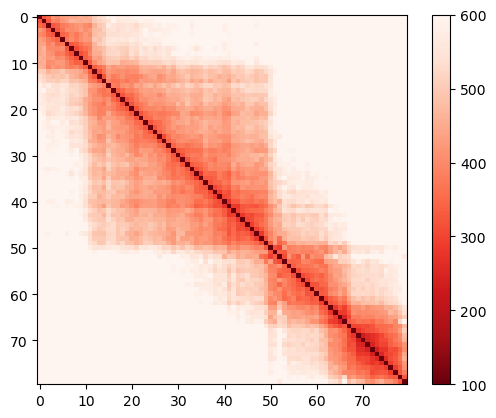

In [4]:
plt.imshow(np.nanmedian(esc_maps, axis=0)[:80, :80], cmap='Reds_r',
           vmin=100, vmax=600)
plt.colorbar()

In [37]:
monomers = 5000  # change this to multiple of ctcf sites 
replicates = 1
lef_lifetime = 20  # 40 gives better result than 10
lef_separation = 10
ctcf_sites = None 
ctcf_capture = 1
ctcf_release = 0.003
ctcf_dir = None 
monomer_types = None 
interaction_matrix = None 
trajectory_length = 1000 * 10  # More samples show better results 
density = 0.2
load_prob = 1/monomers 
gpu_id = "0"
repulsion = 6
lef_flag = True 

In [38]:
ctcf_sites_one_iter = np.array([0, 11, 49, 62, 65, 80])
ctcf_capture_one_iter = np.array([1, 0.9, 0.9, 0.5, 0.9, 1])
ctcf_dir_one_iter = np.array([0, 0, 0, 0, 0, 0])

Max CTCF sites: 80.0
11 11 11
Max CTCF sites: 160.0
16 16 16
Max CTCF sites: 240.0
21 21 21
Max CTCF sites: 320.0
26 26 26
Max CTCF sites: 400.0
31 31 31
Max CTCF sites: 480.0
36 36 36
Max CTCF sites: 560.0
41 41 41
Max CTCF sites: 640.0
46 46 46
Max CTCF sites: 720.0
51 51 51
Max CTCF sites: 800.0
56 56 56
Max CTCF sites: 880.0
61 61 61
Max CTCF sites: 960.0
66 66 66
Max CTCF sites: 1040.0
71 71 71
Max CTCF sites: 1120.0
76 76 76
Max CTCF sites: 1200.0
81 81 81
Max CTCF sites: 1280.0
86 86 86
Max CTCF sites: 1360.0
91 91 91
Max CTCF sites: 1440.0
96 96 96
Max CTCF sites: 1520.0
101 101 101
Max CTCF sites: 1600.0
106 106 106
Max CTCF sites: 1680.0
111 111 111
Max CTCF sites: 1760.0
116 116 116
Max CTCF sites: 1840.0
121 121 121
Max CTCF sites: 1920.0
126 126 126
Max CTCF sites: 2000.0
131 131 131
Max CTCF sites: 2080.0
136 136 136
Max CTCF sites: 2160.0
141 141 141
Max CTCF sites: 2240.0
146 146 146
Max CTCF sites: 2320.0
151 151 151
Max CTCF sites: 2400.0
156 156 156
Max CTCF sites: 2

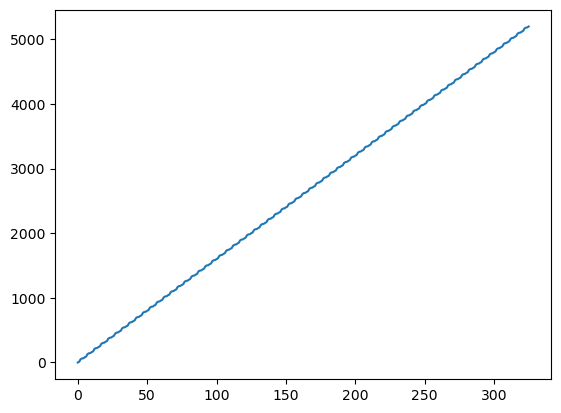

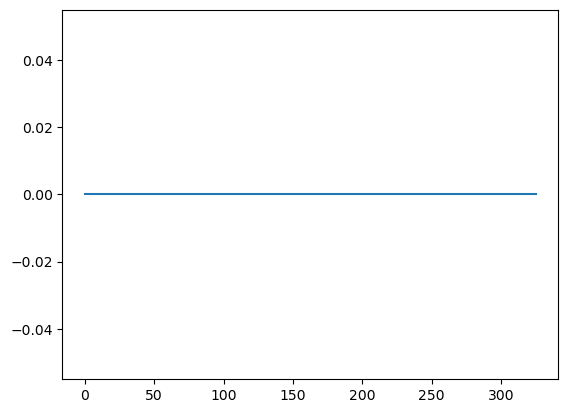

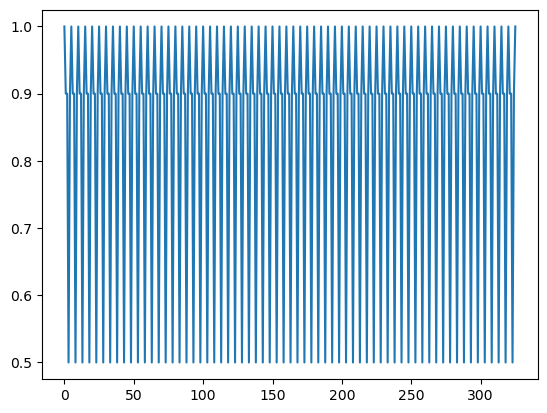

In [39]:
monomers = int(ctcf_sites_one_iter.max())*65

ctcf_sites = np.append(np.zeros([0]), ctcf_sites_one_iter)
ctcf_capture = np.append(np.zeros([0]), ctcf_capture_one_iter)
ctcf_dir = np.append(np.zeros([0]), ctcf_dir_one_iter)

while np.max(ctcf_sites) < monomers:
    print('Max CTCF sites:', np.max(ctcf_sites))
    ctcf_sites_next = np.max(ctcf_sites) + ctcf_sites_one_iter 
    
    ctcf_sites = np.append(ctcf_sites, ctcf_sites_next[1:])
    ctcf_capture = np.append(ctcf_capture, ctcf_capture_one_iter[1:])
    ctcf_dir = np.append(ctcf_dir, ctcf_dir_one_iter[1:])
    
    print(len(ctcf_sites), len(ctcf_dir), len(ctcf_capture))
    
ctcf_sites = ctcf_sites.astype(int)[:monomers]
ctcf_capture = ctcf_capture[:monomers]
ctcf_dir = ctcf_dir[:monomers]

plt.plot(ctcf_sites)
plt.show()
plt.plot(ctcf_dir)
plt.show()

plt.plot(ctcf_capture)

In [40]:
ctcf_release = np.ones_like(ctcf_sites) * ctcf_release
load_prob = np.ones(monomers) * load_prob

monomer_types = np.zeros(monomers, dtype=int)
interaction_matrix = np.array([[0, 0], [0, 0]])

In [41]:
save_folder = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/md_results/20241028_Sox9_Interactive_Empirical/'

In [42]:
# Change here
params = {
    'monomers': monomers,
    'replicates': replicates,
    'lef_lifetime': lef_lifetime,
    'lef_separation': lef_separation,
    'ctcf_capture': ctcf_capture,
    'ctcf_release': ctcf_release,
    'save_folder': save_folder,
    'ctcf_dir': ctcf_dir,
    'ctcf_sites': ctcf_sites,
    'monomer_types': monomer_types,
    'interaction_matrix': interaction_matrix,
    'trajectory_length': trajectory_length,
    'density': density,
    'load_prob': load_prob,
    'gpu_id': gpu_id,
    'repulsion': repulsion,
    'lef_flag': True
}

In [43]:

# general parameters 
trajectoryLength = params['trajectory_length'] # time duration of simulation 
density = params['density'] #  0.2  # fraction of the volume of the sphere which is occupied by the polymer (or effective excluded volume, if using periodic boundary conditions)
  
   
#  ==========Extrusion sim parameters====================
# there is probably a more elegant way to read in text values than ast.literal_eval, but this works.  
GPU_ID = params['gpu_id'] # this should be a string -- which GPU to run on, eg "0", or "1" 
repulsionEnergy = params['repulsion'] # this is just a number
N1 = params['monomers'] # Number of monomers in the polymer/chromosome
M = params['replicates']  # Number of chromosomes in the simulation
num_chains = M  # same as above, multiple variable names were introduced.
N = N1 * M # total number of monomers in the full simulation 
LIFETIME = params['lef_lifetime'] #  extruder lifetime
SEPARATION = params['lef_separation'] # separation between extruders in monomer units (extruder density) 
ctcfSites = params['ctcf_sites'] # CTCF site locations, in monomer units
ctcfDir = params['ctcf_dir']  # CTCF site direction 
ctcfCapture = params['ctcf_capture'] # 0.9 80% capture probability per block, if capture < than this, capture  
ctcfRelease = params['ctcf_release'] # 0.003 % release probability per block, if capture < than this, release
interactionMatrix = params['interaction_matrix']  # interaction strength between different compartments 
saveFolder = params['save_folder']  # place to save the data
oneChainMonomerTypes =  params['monomer_types'] # compartment labels
lefFlag = params['lef_flag']
if len(oneChainMonomerTypes) != N1:
    oneChainMonomerTypes = np.zeros(N1).astype(int)
    
# Allow biased cohesin loading probabilities (e.g. as a function of chromatin state), if desired
loadProb = params['load_prob'] # discrete probability distribution that cohesin loads at site N
loadProb = numpy.matlib.repmat(loadProb,1,M)
loadProb = loadProb/np.sum(loadProb) 

if not os.path.exists(saveFolder):
    os.mkdir(saveFolder)

lefPosFile = saveFolder + "LEFPos.h5"
if lefFlag:
    LEFNum = max(0,math.floor(N // SEPARATION )-1)
else:
    LEFNum = 0

# Optionally, tether the chromosome ends at random positions on the nulcear lamina
#   to use this, line 245 should be replaced with the commented line below it. 
#   select M random points on the edge of sphere
r = 1.05*(3 * N/ (4 * np.pi * density)) ** (1 / 3.0)
theta =np.random.rand(num_chains,1)*np.pi
psi = np.random.rand(num_chains,1)*2*np.pi
x= r*np.cos(psi)*np.sin(theta)
y= r*np.sin(psi)*np.sin(theta)
z= r*np.cos(theta)
end_tethers = np.concatenate((x,y,z),axis=1).tolist() 


# less common parameters
attraction_radius = 1.5
MDstepsPerCohesinStep = 800
smcBondWiggleDist = 0.2
smcBondDist = 0.5
saveEveryBlocks = 100   #
restartSimulationEveryBlocks = 100

# check that these loaded alright
print(f'LEF count: {LEFNum}')
print('interaction matrix:')
print(interactionMatrix)
print('monomer types:')
print(oneChainMonomerTypes)
print(saveFolder)
print('Starting simulation')


LEF count: 519
interaction matrix:
[[0 0]
 [0 0]]
monomer types:
[0 0 0 ... 0 0 0]
/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/md_results/20241028_Sox9_Interactive_Empirical/
Starting simulation


In [44]:


#==================================#
# Run 
#=================================#

#=========== 1D LE Simulation first ============#
import extrusion1Dv2 as ex1D # 1D classes 
ctcfLeftRelease = {}
ctcfRightRelease = {}
ctcfLeftCapture = {}
ctcfRightCapture = {}

# should modify this to allow directionality
for i in range(M): # loop over chains (this variable needs a better name Max)
    for t in range(len(ctcfSites)):
        pos = i * N1 + ctcfSites[t] 
        if ctcfDir[t] == 0:
            ctcfLeftCapture[pos] = ctcfCapture[t]  # if random [0,1] is less than this, capture
            ctcfLeftRelease[pos] = ctcfRelease[t]  # if random [0,1] is less than this, release
            ctcfRightCapture[pos] = ctcfCapture[t]
            ctcfRightRelease[pos] = ctcfRelease[t]
        elif ctcfDir[t] == 1: # stop Cohesin moving toward the right  
            ctcfLeftCapture[pos] = 0  
            ctcfLeftRelease[pos] = 1  
            ctcfRightCapture[pos] = ctcfCapture[t]
            ctcfRightRelease[pos] = ctcfRelease[t]
        elif ctcfDir[t] == 2:
            ctcfLeftCapture[pos] = ctcfCapture[t]  # if random [0,1] is less than this, capture
            ctcfLeftRelease[pos] = ctcfRelease[t]  # if random [0,1] is less than this, release
            ctcfRightCapture[pos] = 0
            ctcfRightRelease[pos] = 1
       
args = {}
args["ctcfRelease"] = {-1:ctcfLeftRelease, 1:ctcfRightRelease}
args["ctcfCapture"] = {-1:ctcfLeftCapture, 1:ctcfRightCapture}        
args["N"] = N 
args["LIFETIME"] = LIFETIME
args["LIFETIME_STALLED"] = LIFETIME  # no change in lifetime when stalled 

occupied = np.zeros(N)
occupied[0] = 1  # (I think this is just prevent the cohesin loading at the end by making it already occupied)
occupied[-1] = 1 # [-1] is "python" for end
cohesins = []

print('starting simulation with N LEFs=')
print(LEFNum)
for i in tqdm(range(LEFNum)):
    ex1D.loadOneFromDist(cohesins,occupied, args,loadProb) # load the cohesins 
    
# if lefPosFile exists, delete it
if os.path.exists(lefPosFile):
    os.remove(lefPosFile)


with h5py.File(lefPosFile, mode='w') as myfile:
    dset = myfile.create_dataset("positions", 
                                 shape=(trajectoryLength, LEFNum, 2), 
                                 dtype=np.int32, 
                                 compression="gzip")
    steps = 100    # saving in 100 chunks because the whole trajectory may be large 
    bins = np.linspace(0, trajectoryLength, steps, dtype=int) # chunks boundaries 
    print(len(bins))
    for st,end in tqdm(zip(bins[:-1], bins[1:])):
        cur = []
        for i in range(st, end):
            ex1D.translocate(cohesins, occupied, args,loadProb)  # actual step of LEF dynamics 
            positions = [(cohesin.left.pos, cohesin.right.pos) for cohesin in cohesins]
            cur.append(positions)  # appending current positions to an array 
        cur = np.array(cur)  # when we finished a block of positions, save it to HDF5 
        dset[st:end] = cur
    myfile.attrs["N"] = N
    myfile.attrs["LEFNum"] = LEFNum
    


starting simulation with N LEFs=
519


  0%|          | 0/519 [00:00<?, ?it/s]

100


0it [00:00, ?it/s]

In [45]:
#=========== Load LEF simulation ===========#
trajectory_file = h5py.File(lefPosFile, mode='r')
LEFNum = trajectory_file.attrs["LEFNum"]  # number of LEFs
LEFpositions = trajectory_file["positions"]  # array of LEF positions  
steps = MDstepsPerCohesinStep # MD steps per step of cohesin  (set to ~800 in real sims)
Nframes = LEFpositions.shape[0] # length of the saved trajectory (>25000 in real sims)
print(f'Length of the saved trajectory: {Nframes}')
block = 0  # starting block 

# test some properties 
# assertions for easy managing code below 
assert (Nframes % restartSimulationEveryBlocks) == 0 
assert (restartSimulationEveryBlocks % saveEveryBlocks) == 0

savesPerSim = restartSimulationEveryBlocks // saveEveryBlocks
simInitsTotal  = (Nframes) // restartSimulationEveryBlocks
# concatinate monomers if needed
if len(oneChainMonomerTypes) != N:
    monomerTypes = np.tile(oneChainMonomerTypes, num_chains)
else:
    monomerTypes = oneChainMonomerTypes
    
N_chain = len(oneChainMonomerTypes)  
N = len(monomerTypes)
print(f'N_chain: {N_chain}')  # ~8000 in a real sim
print(f'N: {N}')   # ~40000 in a real sim
N_traj = trajectory_file.attrs["N"]
print(f'N_traj: {N_traj}')
assert N == trajectory_file.attrs["N"]
print(f'Nframes: {Nframes}')
print(f'simInitsTotal: {simInitsTotal}')


Length of the saved trajectory: 10000
N_chain: 5200
N: 5200
N_traj: 5200
Nframes: 10000
simInitsTotal: 100


In [46]:

#==============================================================#
#      RUN 3D simulation using 1D LEF constraints              #
#==============================================================#
milker = bondUpdater(LEFpositions)
data = grow_cubic(N,int((N/(density*1.2))**0.333))  # starting conformation
reporter = HDF5Reporter(folder=saveFolder, max_data_length=50, overwrite=True)
chains = [(N_chain*(k),N_chain*(k+1),0) for k in range(num_chains)]
positions_all_iterations = []

for iteration in tqdm(range(simInitsTotal)):
    position_curr_iteration = []
    a = Simulation(N=N, 
                   error_tol=0.01, 
                   collision_rate=0.01, 
                   integrator ="variableLangevin", 
                   GPU = "0",
                   platform="CUDA",
                   PBCbox=False, 
                   reporters=[reporter],
                   precision="mixed")  
    a.set_data(data)  # Start from previous positions
    position_curr_iteration.append(a.get_data())
    a.add_force(
        polychrom.forcekits.polymer_chains(
            a,
            chains=chains,
            nonbonded_force_func=polychrom.forces.heteropolymer_SSW,
            nonbonded_force_kwargs={
                'repulsionEnergy': repulsionEnergy,  # base repulsion energy for all monomers (function default is 3.0)
                'attractionEnergy': 0,  # base attraction energy for all monomers (function default is 3.0)
                'attractionRadius': attraction_radius,
                'interactionMatrix': interactionMatrix,
                'monomerTypes': monomerTypes,
                'extraHardParticlesIdxs': []
            },
            bond_force_kwargs={
                'bondLength': 1,
                'bondWiggleDistance': 0.05
            },
            angle_force_kwargs={
                'k': 0.5 
            }
        )
    )
    a.add_force(polychrom.forces.spherical_confinement(a,density=density))
    # a.add_force(polychrom.forces.tether_particles(a,[0,N-1],positions=end_tethers,k=30))  # tether ends of polymer)
    
    # ------------ initializing milker; adding bonds ---------
    kbond = a.kbondScalingFactor / (smcBondWiggleDist ** 2)
    bondDist = smcBondDist * a.length_scale
    activeParams = {"length":bondDist,"k":kbond}
    inactiveParams = {"length":bondDist, "k":0}
    
    milker.setParams(activeParams, inactiveParams)
    # this step actually puts all bonds in and sets first bonds to be what they should be
    milker.setup(bondForce=a.force_dict['harmonic_bonds'],
                blocks=restartSimulationEveryBlocks)

    if iteration == 0:
        a.local_energy_minimization() 
        position_curr_iteration.append(a.get_data())
    else:
        a._apply_forces()
        position_curr_iteration.append(a.get_data())
    
    for i in range(restartSimulationEveryBlocks):        
        if i % saveEveryBlocks == (saveEveryBlocks - 1):  
            a.do_block(steps=steps)
            position_curr_iteration.append(a.get_data())
        else:
            a.integrator.step(steps)  # do steps without getting the positions from the GPU (faster)
            position_curr_iteration.append(a.get_data())
        if i < restartSimulationEveryBlocks - 1: 
            curBonds, pastBonds = milker.step(a.context)  # this updates bonds.
    
    # Change this line - move it inside the for loop to get a movie of the simulation
    data = a.get_data()  # save data and step, and delete the simulation
    
    del a
    
    reporter.blocks_only = False  # Write output hdf5-files only for blocks
    
    time.sleep(0.2)  # wait 200ms for sanity (to let garbage collector do its magic)
    positions_all_iterations.append(position_curr_iteration)

reporter.dump_data()

  0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 30.786639
INFO:root:before minimization eK=1.5033291380759999, eP=30.786638649935515, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.934278
INFO:root:after minimization eK=1.5033291380759999, eP=0.7962155593180166, time=0.0 ps
INFO:root:block    0 pos[1]=[9.7 0.2 -6.4] dr=14.30 t=8877.0ps kin=1.91 pot=1.84 Rg=13.371 SPS=3275 dt=110.8fs dx=34.20pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 3.022052
INFO:root:block    0 pos[1]=[4.4 -13.8 1.2] dr=11.72 t=8869.7ps kin=1.91 pot=1.81 Rg=13.632 SPS=3387 dt=110.7fs dx=34.20pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 2.895677
INFO:root:block    0 pos[1]=[8.5 -8.9 6.5] dr=10.80 t=8900.7ps kin=1.92 pot=1.82 Rg=13.488 SPS=3373 dt=110.8fs dx=34.30pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 2.957783
INFO:root:block    0 pos[1]=[-5.2 -8.5 6.3] dr=9.82 t=8885.3ps kin=1.88 pot=1.83 Rg=13.668 SPS=3363 dt=112.1fs dx=34.33pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 2.886880
INFO:root:block    0 pos[1]=[11.0 -8.2 6.9] dr=11.18 t=8887.9ps kin=1.90 pot=1.84 Rg=13.716 SPS=3324 dt=111.5fs dx=34.35pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 3.047561
INFO:root:block    0 pos[1]=[14.9 2.9 -3.8] dr=10.25 t=8844.1ps kin=1.95 pot=1.84 Rg=13.600 SPS=3331 dt=111.2fs dx=34.66pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 3.007395
INFO:root:block    0 pos[1]=[12.2 4.8 -5.8] dr=10.32 t=8879.1ps kin=1.93 pot=1.86 Rg=13.562 SPS=3317 dt=110.9fs dx=34.39pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 3.162706
INFO:root:block    0 pos[1]=[15.0 -4.3 -5.5] dr=9.93 t=8861.9ps kin=1.85 pot=1.78 Rg=13.468 SPS=3294 dt=118.2fs dx=35.92pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 2.820561
INFO:root:block    0 pos[1]=[10.0 -1.4 7.7] dr=10.91 t=8905.8ps kin=1.88 pot=1.80 Rg=13.631 SPS=3340 dt=111.7fs dx=34.16pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 2.822621
INFO:root:block    0 pos[1]=[14.9 -1.9 -10.2] dr=10.79 t=8876.6ps kin=1.96 pot=1.89 Rg=13.666 SPS=3358 dt=110.6fs dx=34.60pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 3.186419
INFO:root:block    0 pos[1]=[7.6 0.0 9.5] dr=10.57 t=8835.8ps kin=1.92 pot=1.85 Rg=13.630 SPS=3326 dt=110.2fs dx=34.15pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 3.039683
INFO:root:block    0 pos[1]=[10.1 -0.1 12.3] dr=11.44 t=8886.2ps kin=1.97 pot=1.88 Rg=13.750 SPS=3343 dt=110.6fs dx=34.69pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 3.095439
INFO:root:block    0 pos[1]=[15.1 -1.7 -2.4] dr=10.44 t=8860.5ps kin=1.94 pot=1.87 Rg=13.598 SPS=3383 dt=110.2fs dx=34.29pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 3.038567
INFO:root:block    0 pos[1]=[10.6 -6.9 0.2] dr=10.89 t=8873.4ps kin=1.88 pot=1.83 Rg=13.642 SPS=3317 dt=111.2fs dx=34.06pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 2.953637
INFO:root:block    0 pos[1]=[11.6 -6.5 -1.1] dr=10.26 t=8871.5ps kin=1.84 pot=1.80 Rg=13.670 SPS=3307 dt=118.4fs dx=35.93pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 3.016414
INFO:root:block    0 pos[1]=[12.9 -0.2 -11.0] dr=10.09 t=8862.3ps kin=1.97 pot=1.92 Rg=13.850 SPS=3389 dt=110.4fs dx=34.62pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 3.167772
INFO:root:block    0 pos[1]=[6.3 3.8 -12.6] dr=9.72 t=8858.3ps kin=1.94 pot=1.82 Rg=13.661 SPS=3325 dt=110.7fs dx=34.45pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 2.976212
INFO:root:block    0 pos[1]=[8.5 4.9 -9.6] dr=9.72 t=8888.9ps kin=1.83 pot=1.86 Rg=13.558 SPS=3347 dt=111.8fs dx=33.81pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 3.071188
INFO:root:block    0 pos[1]=[-3.3 -11.1 -4.3] dr=10.31 t=8857.7ps kin=1.91 pot=1.84 Rg=13.605 SPS=3336 dt=110.3fs dx=34.06pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 2.959916
INFO:root:block    0 pos[1]=[-3.0 -16.6 -6.6] dr=11.23 t=8880.8ps kin=1.89 pot=1.81 Rg=13.629 SPS=3312 dt=110.9fs dx=34.08pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 3.045837
INFO:root:block    0 pos[1]=[-5.5 -1.0 -11.2] dr=11.15 t=8868.2ps kin=1.87 pot=1.83 Rg=13.617 SPS=3341 dt=110.6fs dx=33.80pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 3.022703
INFO:root:block    0 pos[1]=[0.3 0.6 -16.6] dr=9.66 t=8888.6ps kin=1.87 pot=1.78 Rg=13.565 SPS=3331 dt=110.8fs dx=33.88pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 2.803679
INFO:root:block    0 pos[1]=[8.8 -1.4 -14.3] dr=9.85 t=8872.4ps kin=1.90 pot=1.83 Rg=13.639 SPS=3356 dt=110.6fs dx=34.07pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 2.907741
INFO:root:block    0 pos[1]=[-2.6 3.1 -14.0] dr=11.02 t=8858.8ps kin=1.90 pot=1.85 Rg=13.599 SPS=3336 dt=110.7fs dx=34.05pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 2.913531
INFO:root:block    0 pos[1]=[12.0 7.2 -12.2] dr=10.54 t=8870.0ps kin=1.88 pot=1.86 Rg=13.573 SPS=3343 dt=111.8fs dx=34.26pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 2.892139
INFO:root:block    0 pos[1]=[-4.2 9.1 -13.4] dr=12.10 t=8905.1ps kin=1.91 pot=1.84 Rg=13.704 SPS=3313 dt=111.3fs dx=34.31pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 2.996991
INFO:root:block    0 pos[1]=[8.6 -0.6 -15.4] dr=10.24 t=8879.9ps kin=1.91 pot=1.85 Rg=13.469 SPS=3364 dt=110.5fs dx=34.13pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 2.948184
INFO:root:block    0 pos[1]=[13.1 2.3 -5.9] dr=9.48 t=8897.4ps kin=1.93 pot=1.84 Rg=13.705 SPS=3320 dt=111.4fs dx=34.52pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 3.047135
INFO:root:block    0 pos[1]=[2.2 -15.1 -5.5] dr=10.94 t=8874.8ps kin=1.89 pot=1.83 Rg=13.527 SPS=3298 dt=110.9fs dx=34.03pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 2.910286
INFO:root:block    0 pos[1]=[-5.3 -14.8 -2.2] dr=11.42 t=8866.5ps kin=1.89 pot=1.82 Rg=13.673 SPS=3353 dt=110.8fs dx=34.06pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 2.867211
INFO:root:block    0 pos[1]=[1.6 -14.3 -7.1] dr=11.08 t=8902.9ps kin=1.92 pot=1.87 Rg=13.653 SPS=3430 dt=111.1fs dx=34.41pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 3.047059
INFO:root:block    0 pos[1]=[-11.1 -10.5 1.9] dr=10.01 t=8891.6ps kin=1.90 pot=1.84 Rg=13.370 SPS=3320 dt=110.6fs dx=34.03pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 3.051078
INFO:root:block    0 pos[1]=[-10.3 -4.5 10.6] dr=10.02 t=8894.0ps kin=1.91 pot=1.86 Rg=13.550 SPS=3353 dt=110.5fs dx=34.06pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 2.986999
INFO:root:block    0 pos[1]=[-7.0 3.9 16.4] dr=9.70 t=8869.2ps kin=1.96 pot=1.90 Rg=13.686 SPS=3318 dt=110.3fs dx=34.52pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 3.257508
INFO:root:block    0 pos[1]=[-1.9 -8.3 13.1] dr=10.56 t=8884.0ps kin=1.81 pot=1.79 Rg=13.560 SPS=3322 dt=112.6fs dx=33.82pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 2.934712
INFO:root:block    0 pos[1]=[4.8 -10.4 6.0] dr=9.90 t=8887.9ps kin=1.90 pot=1.80 Rg=13.674 SPS=3407 dt=110.2fs dx=33.89pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 2.996920
INFO:root:block    0 pos[1]=[8.0 -3.8 12.8] dr=10.44 t=8879.2ps kin=1.86 pot=1.81 Rg=13.569 SPS=3358 dt=111.9fs dx=34.06pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 2.819979
INFO:root:block    0 pos[1]=[6.4 -14.0 -0.2] dr=9.39 t=8915.3ps kin=1.89 pot=1.84 Rg=13.642 SPS=3368 dt=111.7fs dx=34.30pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 2.840381
INFO:root:block    0 pos[1]=[5.6 -8.1 -0.1] dr=9.87 t=8899.4ps kin=1.98 pot=1.84 Rg=13.697 SPS=3381 dt=110.7fs dx=34.76pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 3.195046
INFO:root:block    0 pos[1]=[2.7 -16.1 6.3] dr=9.69 t=8875.4ps kin=1.87 pot=1.82 Rg=13.626 SPS=3418 dt=110.2fs dx=33.69pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 2.926777
INFO:root:block    0 pos[1]=[-2.5 -3.3 5.7] dr=10.68 t=8883.9ps kin=1.97 pot=1.83 Rg=13.434 SPS=3338 dt=109.9fs dx=34.48pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 3.177417
INFO:root:block    0 pos[1]=[-3.0 -7.1 13.3] dr=9.66 t=8868.7ps kin=1.93 pot=1.87 Rg=13.783 SPS=3349 dt=110.8fs dx=34.37pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 3.035718
INFO:root:block    0 pos[1]=[-14.3 -1.0 7.4] dr=11.15 t=8851.3ps kin=1.88 pot=1.85 Rg=13.752 SPS=3335 dt=110.6fs dx=33.91pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 2.982281
INFO:root:block    0 pos[1]=[-2.8 6.9 12.0] dr=9.95 t=8897.3ps kin=1.88 pot=1.83 Rg=13.671 SPS=3321 dt=111.1fs dx=33.98pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 2.857984
INFO:root:block    0 pos[1]=[5.0 12.8 4.8] dr=9.89 t=8898.6ps kin=1.91 pot=1.85 Rg=13.658 SPS=3335 dt=111.0fs dx=34.26pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 3.088848
INFO:root:block    0 pos[1]=[-1.7 3.8 10.1] dr=10.95 t=8864.7ps kin=1.93 pot=1.84 Rg=13.634 SPS=3313 dt=111.1fs dx=34.47pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 3.093203
INFO:root:block    0 pos[1]=[-4.5 -3.7 7.8] dr=11.63 t=8853.0ps kin=1.88 pot=1.86 Rg=13.594 SPS=3329 dt=110.6fs dx=33.90pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 2.962650
INFO:root:block    0 pos[1]=[4.7 -16.9 4.5] dr=12.63 t=8883.6ps kin=1.89 pot=1.85 Rg=13.723 SPS=3387 dt=110.7fs dx=34.00pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 3.034725
INFO:root:block    0 pos[1]=[-6.8 -13.2 0.2] dr=11.30 t=8890.5ps kin=1.84 pot=1.79 Rg=13.623 SPS=3323 dt=111.2fs dx=33.70pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 2.934132
INFO:root:block    0 pos[1]=[4.3 -9.9 5.2] dr=11.35 t=8894.9ps kin=1.85 pot=1.82 Rg=13.644 SPS=3326 dt=110.6fs dx=33.58pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 2.990404
INFO:root:block    0 pos[1]=[-5.2 -2.5 12.9] dr=10.92 t=8904.8ps kin=1.89 pot=1.85 Rg=13.551 SPS=3288 dt=110.9fs dx=34.03pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 2.939093
INFO:root:block    0 pos[1]=[-6.4 9.6 12.7] dr=10.05 t=8861.7ps kin=1.85 pot=1.81 Rg=13.493 SPS=3331 dt=111.1fs dx=33.74pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 2.925365
INFO:root:block    0 pos[1]=[5.0 5.1 8.6] dr=10.16 t=8890.6ps kin=1.86 pot=1.83 Rg=13.529 SPS=3311 dt=112.7fs dx=34.35pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 3.106519
INFO:root:block    0 pos[1]=[13.8 7.9 7.4] dr=10.12 t=8869.7ps kin=1.85 pot=1.81 Rg=13.664 SPS=3382 dt=118.4fs dx=35.98pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 2.924110
INFO:root:block    0 pos[1]=[8.7 -4.5 5.4] dr=10.59 t=8897.1ps kin=1.86 pot=1.81 Rg=13.696 SPS=3314 dt=111.1fs dx=33.85pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 2.859720
INFO:root:block    0 pos[1]=[3.6 -2.2 15.3] dr=10.85 t=8892.0ps kin=1.85 pot=1.83 Rg=13.645 SPS=3394 dt=110.8fs dx=33.68pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 2.945853
INFO:root:block    0 pos[1]=[16.5 2.8 8.1] dr=11.00 t=8848.7ps kin=1.83 pot=1.83 Rg=13.571 SPS=3361 dt=110.3fs dx=33.38pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 2.767010
INFO:root:block    0 pos[1]=[8.0 -6.1 12.1] dr=10.39 t=8894.3ps kin=1.85 pot=1.84 Rg=13.858 SPS=3340 dt=112.1fs dx=34.09pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 3.079762
INFO:root:block    0 pos[1]=[-11.4 -7.4 11.3] dr=10.87 t=8889.3ps kin=1.89 pot=1.82 Rg=13.746 SPS=3324 dt=110.8fs dx=34.02pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 2.818410
INFO:root:block    0 pos[1]=[8.7 -12.0 4.3] dr=11.12 t=8883.6ps kin=1.92 pot=1.84 Rg=13.554 SPS=3326 dt=110.2fs dx=34.10pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 2.932688
INFO:root:block    0 pos[1]=[-8.9 -6.2 11.9] dr=12.05 t=8889.5ps kin=1.89 pot=1.82 Rg=13.552 SPS=3278 dt=111.2fs dx=34.16pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 3.053279
INFO:root:block    0 pos[1]=[-2.8 -11.9 -2.1] dr=9.45 t=8874.6ps kin=1.95 pot=1.87 Rg=13.627 SPS=3333 dt=110.7fs dx=34.49pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 2.957082
INFO:root:block    0 pos[1]=[9.7 -9.9 -5.3] dr=10.58 t=8867.5ps kin=1.89 pot=1.79 Rg=13.840 SPS=3326 dt=110.7fs dx=34.01pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 3.052918
INFO:root:block    0 pos[1]=[-2.9 -11.8 -13.8] dr=10.39 t=8888.6ps kin=1.89 pot=1.85 Rg=13.598 SPS=3364 dt=111.8fs dx=34.29pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 2.950005
INFO:root:block    0 pos[1]=[3.2 -10.0 -12.9] dr=10.52 t=8868.9ps kin=1.88 pot=1.85 Rg=13.542 SPS=3358 dt=111.4fs dx=34.12pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 3.074092
INFO:root:block    0 pos[1]=[5.5 -11.6 -5.8] dr=9.76 t=8868.8ps kin=1.90 pot=1.86 Rg=13.605 SPS=3373 dt=110.6fs dx=34.00pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 3.030440
INFO:root:block    0 pos[1]=[2.4 -6.8 -3.3] dr=10.54 t=8880.4ps kin=1.94 pot=1.88 Rg=13.664 SPS=3347 dt=110.4fs dx=34.36pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 3.035065
INFO:root:block    0 pos[1]=[10.4 -12.4 -4.1] dr=9.79 t=8889.0ps kin=1.93 pot=1.86 Rg=13.572 SPS=3345 dt=110.7fs dx=34.33pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 3.116857
INFO:root:block    0 pos[1]=[8.8 -2.6 -15.7] dr=11.62 t=8848.6ps kin=1.96 pot=1.86 Rg=13.613 SPS=3319 dt=110.1fs dx=34.42pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 3.022212
INFO:root:block    0 pos[1]=[1.8 -13.8 -7.4] dr=11.53 t=8879.4ps kin=1.91 pot=1.84 Rg=13.448 SPS=3344 dt=111.0fs dx=34.28pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 2.854479
INFO:root:block    0 pos[1]=[4.2 2.6 -13.4] dr=10.18 t=8882.5ps kin=1.89 pot=1.86 Rg=13.504 SPS=3374 dt=110.8fs dx=33.98pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 3.143251
INFO:root:block    0 pos[1]=[-2.7 3.1 -15.0] dr=10.26 t=8876.5ps kin=1.94 pot=1.84 Rg=13.622 SPS=3318 dt=110.8fs dx=34.45pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 2.946065
INFO:root:block    0 pos[1]=[0.6 -3.9 -14.5] dr=10.02 t=8877.4ps kin=1.90 pot=1.85 Rg=13.788 SPS=3350 dt=110.2fs dx=33.97pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 3.015522
INFO:root:block    0 pos[1]=[10.1 3.7 -13.9] dr=10.47 t=8872.2ps kin=1.93 pot=1.84 Rg=13.825 SPS=3414 dt=110.8fs dx=34.39pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 2.991397
INFO:root:block    0 pos[1]=[2.9 13.5 -0.1] dr=11.88 t=8909.3ps kin=1.92 pot=1.85 Rg=13.779 SPS=3319 dt=112.0fs dx=34.63pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 3.076031
INFO:root:block    0 pos[1]=[-1.6 13.4 2.2] dr=9.30 t=8845.3ps kin=1.92 pot=1.84 Rg=13.649 SPS=3336 dt=110.2fs dx=34.11pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 3.019369
INFO:root:block    0 pos[1]=[-3.9 13.9 -5.2] dr=10.35 t=8874.0ps kin=1.88 pot=1.83 Rg=13.475 SPS=3282 dt=110.2fs dx=33.73pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 2.922511
INFO:root:block    0 pos[1]=[-9.4 11.5 -2.0] dr=10.46 t=8892.0ps kin=1.90 pot=1.83 Rg=13.643 SPS=3322 dt=110.5fs dx=33.99pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 3.056872
INFO:root:block    0 pos[1]=[7.1 10.1 -0.7] dr=10.73 t=8862.1ps kin=1.89 pot=1.83 Rg=13.616 SPS=3295 dt=110.7fs dx=33.98pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 3.039090
INFO:root:block    0 pos[1]=[-6.4 16.3 -0.2] dr=10.19 t=8889.1ps kin=1.94 pot=1.84 Rg=13.643 SPS=3325 dt=111.0fs dx=34.52pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 3.114671
INFO:root:block    0 pos[1]=[15.1 4.5 3.9] dr=12.07 t=8880.7ps kin=1.95 pot=1.88 Rg=13.517 SPS=3305 dt=111.0fs dx=34.62pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 3.119216
INFO:root:block    0 pos[1]=[6.3 8.4 2.8] dr=9.72 t=8880.5ps kin=1.87 pot=1.84 Rg=13.587 SPS=3330 dt=110.8fs dx=33.82pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 2.855505
INFO:root:block    0 pos[1]=[-2.1 -6.9 -10.7] dr=11.68 t=8864.0ps kin=1.87 pot=1.83 Rg=13.633 SPS=3350 dt=110.3fs dx=33.73pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 2.989470
INFO:root:block    0 pos[1]=[-9.1 -2.5 -10.8] dr=9.69 t=8881.7ps kin=1.91 pot=1.83 Rg=13.575 SPS=3359 dt=110.9fs dx=34.23pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 2.997691
INFO:root:block    0 pos[1]=[-8.5 3.9 -12.2] dr=10.26 t=8898.8ps kin=1.85 pot=1.79 Rg=13.599 SPS=3396 dt=111.0fs dx=33.68pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 2.925975
INFO:root:block    0 pos[1]=[-2.4 -6.1 -12.1] dr=9.49 t=8889.6ps kin=1.91 pot=1.82 Rg=13.528 SPS=3301 dt=111.0fs dx=34.29pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 2.892185
INFO:root:block    0 pos[1]=[3.0 -1.2 -11.1] dr=9.90 t=8868.9ps kin=1.85 pot=1.82 Rg=13.682 SPS=3295 dt=110.7fs dx=33.66pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 2.962529
INFO:root:block    0 pos[1]=[-3.8 2.3 -15.4] dr=10.48 t=8876.5ps kin=1.91 pot=1.85 Rg=13.555 SPS=3366 dt=111.8fs dx=34.50pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 3.029318
INFO:root:block    0 pos[1]=[-8.6 0.2 -15.1] dr=12.76 t=8927.0ps kin=1.90 pot=1.81 Rg=13.578 SPS=3317 dt=111.5fs dx=34.31pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 2.988182
INFO:root:block    0 pos[1]=[-6.2 9.4 -9.8] dr=11.84 t=8889.1ps kin=1.92 pot=1.83 Rg=13.713 SPS=3353 dt=110.8fs dx=34.26pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 3.068577
INFO:root:block    0 pos[1]=[-7.7 7.6 -7.8] dr=12.59 t=8898.9ps kin=1.89 pot=1.86 Rg=13.695 SPS=3411 dt=111.0fs dx=34.13pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 2.980272
INFO:root:block    0 pos[1]=[-1.2 8.6 -12.4] dr=10.73 t=8894.6ps kin=1.87 pot=1.84 Rg=13.658 SPS=3336 dt=112.1fs dx=34.23pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 3.038368
INFO:root:block    0 pos[1]=[0.4 13.3 -8.1] dr=10.89 t=8899.9ps kin=1.91 pot=1.85 Rg=13.598 SPS=3329 dt=111.3fs dx=34.36pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 2.956119
INFO:root:block    0 pos[1]=[-0.3 13.3 2.4] dr=10.25 t=8914.4ps kin=1.88 pot=1.82 Rg=13.616 SPS=3333 dt=111.1fs dx=34.00pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 2.942599
INFO:root:block    0 pos[1]=[5.8 11.1 -9.3] dr=11.63 t=8854.6ps kin=1.86 pot=1.87 Rg=13.658 SPS=3332 dt=110.5fs dx=33.71pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 3.012729
INFO:root:block    0 pos[1]=[5.8 8.9 -12.0] dr=10.04 t=8869.6ps kin=1.86 pot=1.81 Rg=13.626 SPS=3315 dt=111.6fs dx=34.03pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 3.011388
INFO:root:block    0 pos[1]=[-0.1 11.1 -14.1] dr=11.79 t=8880.8ps kin=1.85 pot=1.84 Rg=13.588 SPS=3352 dt=110.7fs dx=33.65pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 2.689297
INFO:root:block    0 pos[1]=[9.1 5.6 -0.3] dr=10.50 t=8886.9ps kin=1.86 pot=1.83 Rg=13.536 SPS=3339 dt=110.6fs dx=33.65pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 3.074025
INFO:root:block    0 pos[1]=[-1.9 12.4 -9.2] dr=9.88 t=8895.6ps kin=1.92 pot=1.87 Rg=13.473 SPS=3382 dt=111.7fs dx=34.57pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Particles loaded. Potential energy is 3.125895
INFO:root:block    0 pos[1]=[-4.0 3.4 -12.5] dr=12.56 t=8859.6ps kin=1.90 pot=1.87 Rg=13.807 SPS=3342 dt=112.0fs dx=34.51pm 


In [50]:
positions_all_iterations = np.array(positions_all_iterations)
sample_polys = []
sample_dmaps = []
for sample in positions_all_iterations:
    sample_polys.append(sample[-1, :, :])
    sample_dmaps.append(squareform(pdist(sample[-1, :, :])))

In [54]:
# Save the map every 80 monomers 
sample_dmaps = np.array(sample_dmaps)
sample_polys = np.array(sample_polys)

In [55]:
sample_dmaps.shape

(100, 5200, 5200)

In [67]:
sample_dmaps_all = []
sample_polys_all = []

num_iters = sample_dmaps.shape[1] // 80
num_reps = sample_dmaps.shape[0]
for i in range(num_reps):
    curr_polys = sample_polys[i, :, :]
    curr_dmaps = sample_dmaps[i, :, :]
    for j in range(num_iters):
        sample_dmaps_all.append(curr_dmaps[j*80:(j+1)*80, j*80:(j+1)*80])
        sample_polys_all.append(curr_polys[j*80:(j+1)*80, :])

In [69]:
sample_median_maps = np.median(sample_dmaps_all, axis=0)

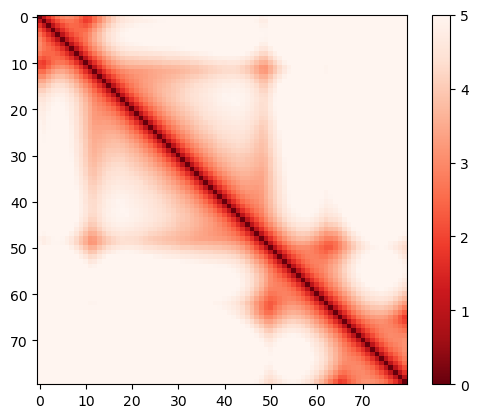

In [70]:
plt.imshow(sample_median_maps[:80, :80], cmap='Reds_r', vmin=0, vmax=5)
plt.colorbar()

In [71]:
contact_threshold = np.mean(np.diag(sample_median_maps, 1))
contact_threshold

1.0033421519308605

In [84]:
sample_cmaps_all = np.array(sample_dmaps_all) < 3

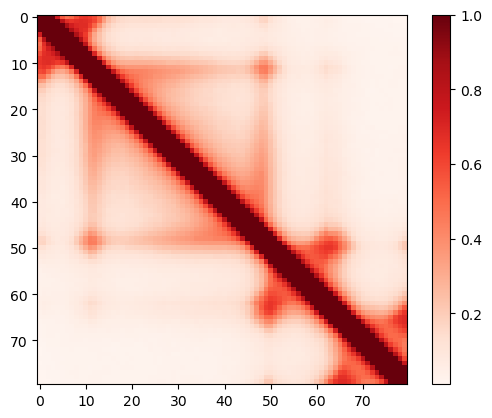

In [85]:
plt.imshow(np.mean(sample_cmaps_all, axis=0), cmap='Reds')
plt.colorbar()